## Setup

In [239]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns

In [240]:
biotic_df = pd.read_excel('../data/PHYTO.xlsx', sheet_name='PHYTO_ONDATE')
biotic_columns = biotic_df.columns
biotic_df.head()


,LOC_CODE,DATUMTIJDWAARDE,Acn,Aco,Ata,Agl,Cfu,Ccu,Cda,Cdeb,...,Rst,Rte,Stu,Tni,Tec,Tle,Tno,Tro,Tor,Dat
0,DANTZGT,1990-04-04,NaN,NaN,NaN,3.271842,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.669596,3.572755,3.572755,NaN,4.475787,NaN,NaN
1,DANTZGT,1990-04-24,NaN,NaN,NaN,4.590418,NaN,NaN,NaN,NaN,...,NaN,NaN,2.448706,3.447933,NaN,NaN,NaN,3.447933,NaN,NaN
2,DANTZGT,1990-05-09,NaN,NaN,NaN,4.669596,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.012035,1.973128,NaN
3,DANTZGT,1990-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.590842,NaN,NaN
4,DANTZGT,1990-06-07,NaN,NaN,2.267172,5.300487,2.444045,NaN,NaN,NaN,...,NaN,NaN,NaN,3.566909,1.968483,3.442009,NaN,3.496376,1.968483,NaN


In [241]:
abiotic_df = pd.read_excel('../data/ABIO.xlsx', sheet_name='ABIO_AGGREGATED')
abiotic_df = abiotic_df.drop("AGG", axis=1)
abiotic_columns = abiotic_df.columns
abiotic_df.head()

,LOC_CODE,DATUMTIJDWAARDE,ZS,ZICHT,T,SiO2,SALNTT,PO4,pH,NO3,NO2,NH4,E,CHLFa
0,DANTZGT,1990-04-04,113.0,3.0,8.2,6.285714,28.79,0.806452,8.1,40.000000,2.000000,6.428571,NaN,25.0
1,DANTZGT,1990-06-02,295.0,0.5,6.0,NaN,27.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DANTZGT,1990-06-20,33.0,10.0,18.1,8.607143,32.69,1.451613,8.3,0.285714,0.142857,2.142857,NaN,6.2
3,DANTZGT,1990-07-18,39.0,4.0,17.0,6.071429,31.90,1.935484,8.2,0.357143,0.714286,4.285714,NaN,7.9
4,DANTZGT,1990-08-03,103.0,3.0,7.3,19.428571,24.99,0.709677,8.0,89.285714,2.071429,8.642857,NaN,21.1


---
## Quick Helper functions

In [242]:
location_time_set = {"LOC_CODE", "DATUMTIJDWAARDE"}

def plot_data_distributions(input, columns=[], subplotsize=(4, 4), colcount=4, bins=10):

    if len(columns) == 0:
        columns = list(set(input.columns) - location_time_set)

    print(columns)

    rowcount = int(math.ceil(len(columns) / colcount))
    
    fig, ax = plt.subplots(rowcount, colcount, 
                           figsize=(subplotsize[1] * colcount, subplotsize[0] * rowcount))

    for i, column in enumerate(columns):
        ax[i // colcount][i % colcount].hist(input[column], bins=bins)
        ax[i // colcount][i % colcount].set_title(column)

---

In [243]:
species_columns = list(set(biotic_columns) - location_time_set)

phyto_corr_matrix = biotic_df[species_columns].corr()
phyto_corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)


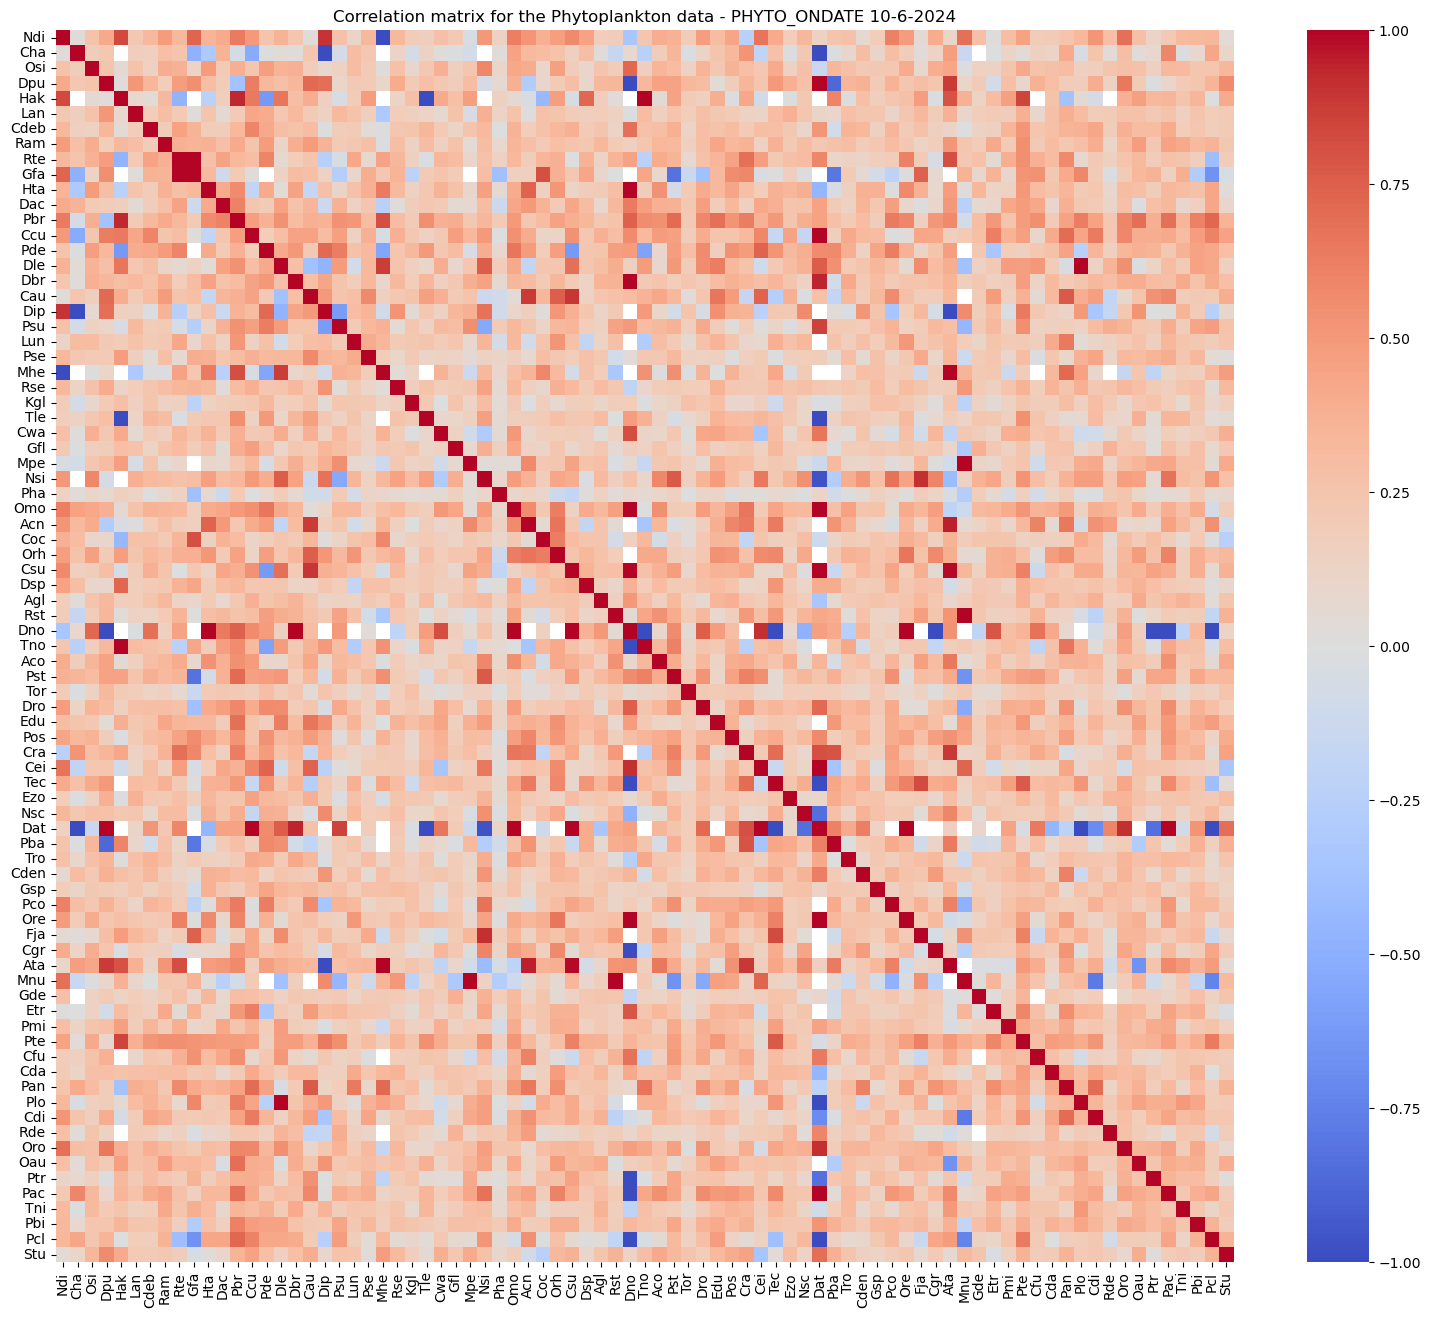

In [244]:
fig, ax = plt.subplots(figsize=(19,16))
plt.title("Correlation matrix for the Phytoplankton data - PHYTO_ONDATE 10-6-2024")
sns.heatmap(phyto_corr_matrix, cmap=plt.get_cmap('coolwarm'), cbar=True, ax=ax)
plt.savefig('phyto_corr_matrix.png')

<Axes: title={'center': 'Correlation matrix for the Phytoplankton data with abs(correlation) > 0.5 - PHYTO_ONDATE 10-6-2024'}>

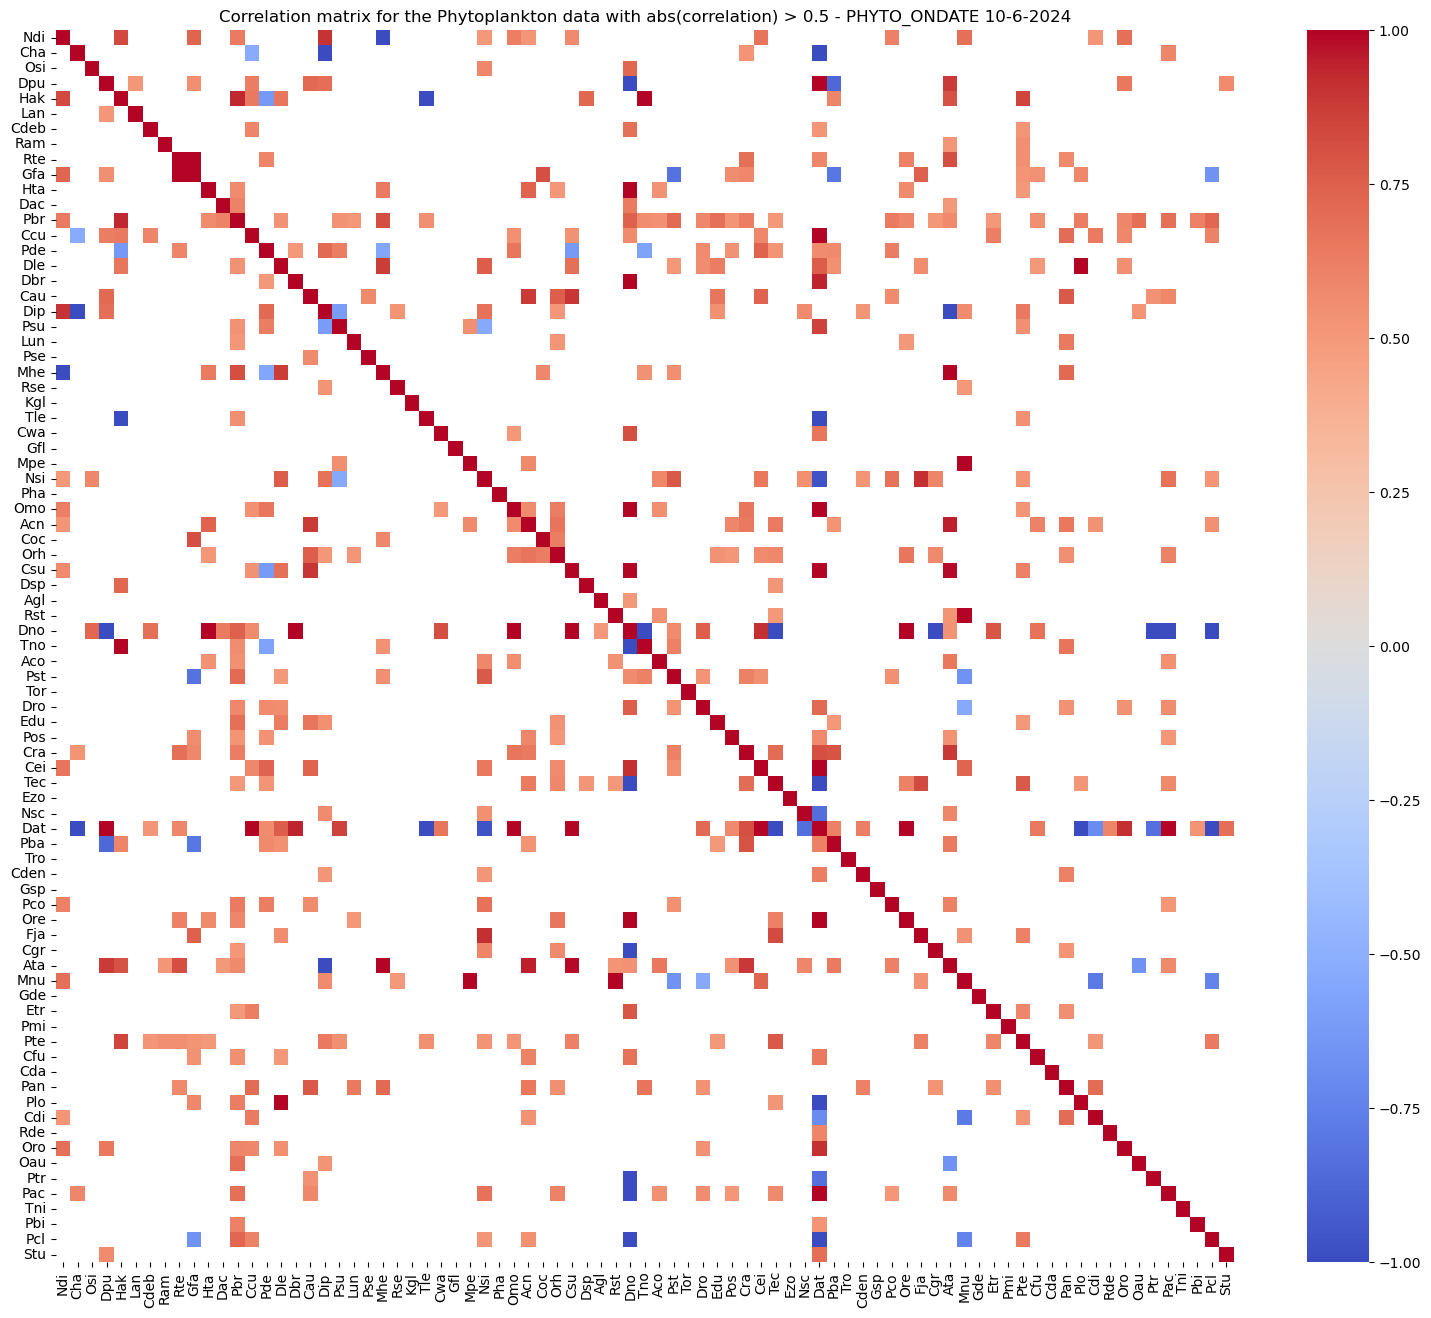

In [245]:
# setting a threshold for the max subset correlation matrix
intensity_threshold = 0.5

threshold_phyto_corr_matrix = phyto_corr_matrix.mask(abs(phyto_corr_matrix) < intensity_threshold)

fig, ax = plt.subplots(figsize=(19,16))
plt.title(f"Correlation matrix for the Phytoplankton data with abs(correlation) > {intensity_threshold} - PHYTO_ONDATE 10-6-2024")
sns.heatmap(threshold_phyto_corr_matrix, cmap=plt.get_cmap('coolwarm'), cbar=True, ax=ax)

In [246]:
percent_missing = biotic_df.isnull().sum() * 100 / len(biotic_df)

print(percent_missing.to_string())

LOC_CODE            0.000000
DATUMTIJDWAARDE     0.000000
Acn                96.538010
Aco                93.979933
Ata                98.354877
Agl                74.961584
Cfu                90.156377
Ccu                95.308687
Cda                86.983639
Cdeb               83.033535
Cden               90.002712
Cdi                92.470397
Cei                95.796800
Csu                89.668264
Cha                97.559432
Coc                94.034168
Cau                97.351532
Cgr                95.534665
Cra                94.377655
Cwa                95.272530
Dpu                96.754949
Dsp                93.907620
Dac                92.886197
Dno                98.915303
Dro                92.190183
Dip                94.513242
Dle                95.887192
Dbr                72.240803
Etr                88.041218
Ezo                81.207629
Edu                82.247130
Fja                94.106481
Gde                69.257887
Gfl                73.063364
Gsp           

['NO2', 'SiO2', 'E', 'CHLFa', 'SALNTT', 'NH4', 'PO4', 'T', 'pH', 'ZICHT', 'NO3', 'ZS']
LOC_CODE            0.000000
DATUMTIJDWAARDE     0.000000
ZS                  5.804129
ZICHT              56.682095
T                   7.530674
SiO2                7.192712
SALNTT             12.276835
PO4                 7.038425
pH                  9.338035
NO3                 9.698038
NO2                 6.979649
NH4                 7.155977
E                  63.669091
CHLFa               7.971494


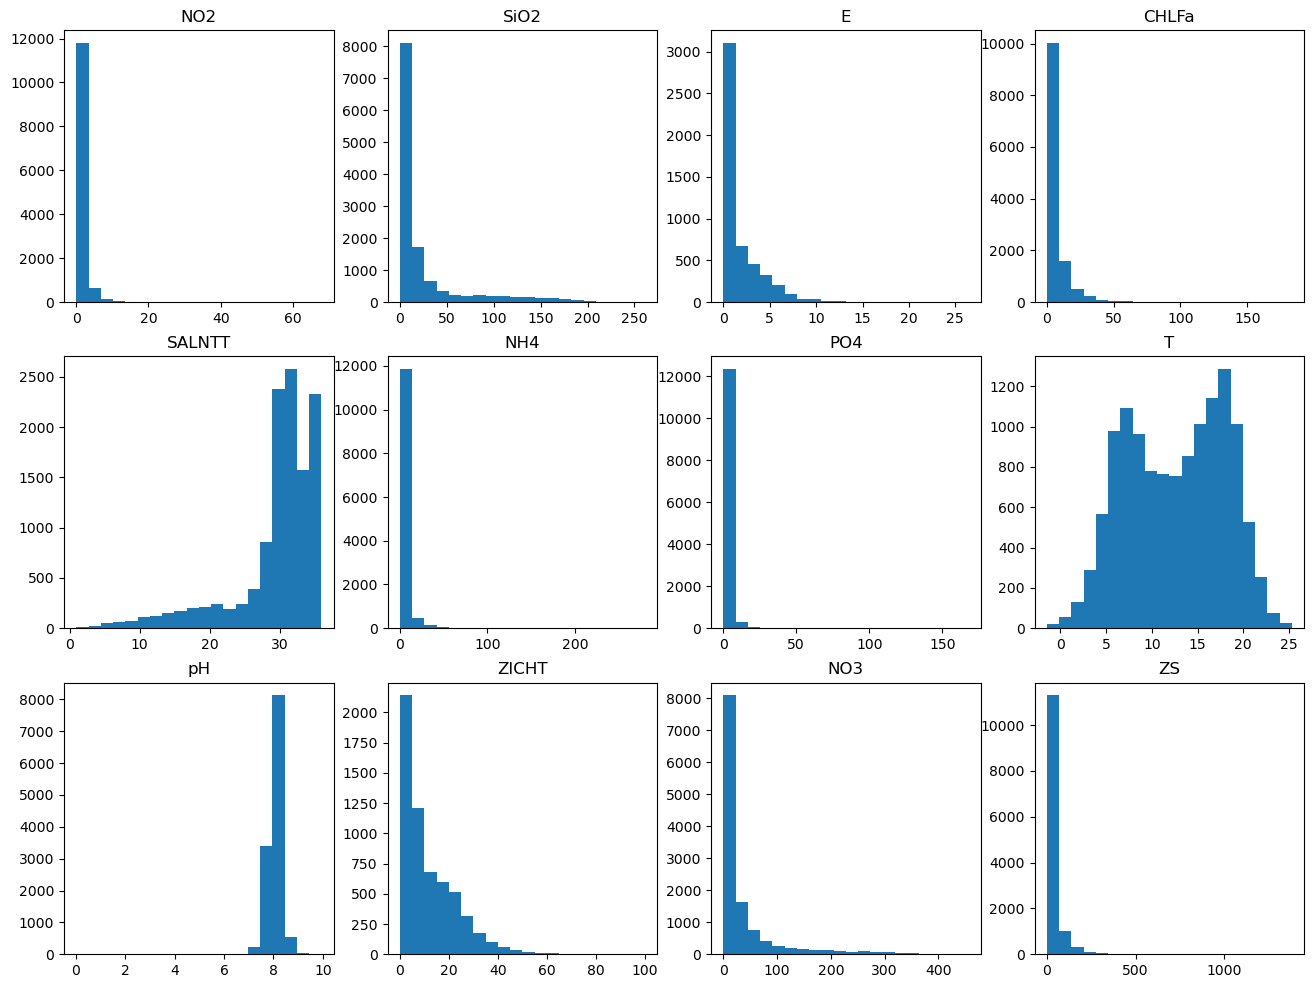

In [247]:
percent_missing = abiotic_df.isnull().sum() * 100 / len(abiotic_df)

plot_data_distributions(abiotic_df, bins=20)

print(percent_missing.to_string())

We did a lil interpolation below, but the "ZICHT" column still has around 42% missing values, since i only interpolate within the grouped dates for locations and some locations have no ZICHT measurements

['NO2', 'SiO2', 'E', 'CHLFa', 'SALNTT', 'NH4', 'PO4', 'T', 'pH', 'ZICHT', 'NO3', 'ZS']
LOC_CODE            0.000000
DATUMTIJDWAARDE     0.000000
ZS                  0.000000
ZICHT              41.892587
T                   0.000000
SiO2                0.000000
SALNTT              0.000000
PO4                 0.000000
pH                  0.000000
NO3                 0.000000
NO2                 0.000000
NH4                 0.000000
E                   0.000000
CHLFa               0.000000


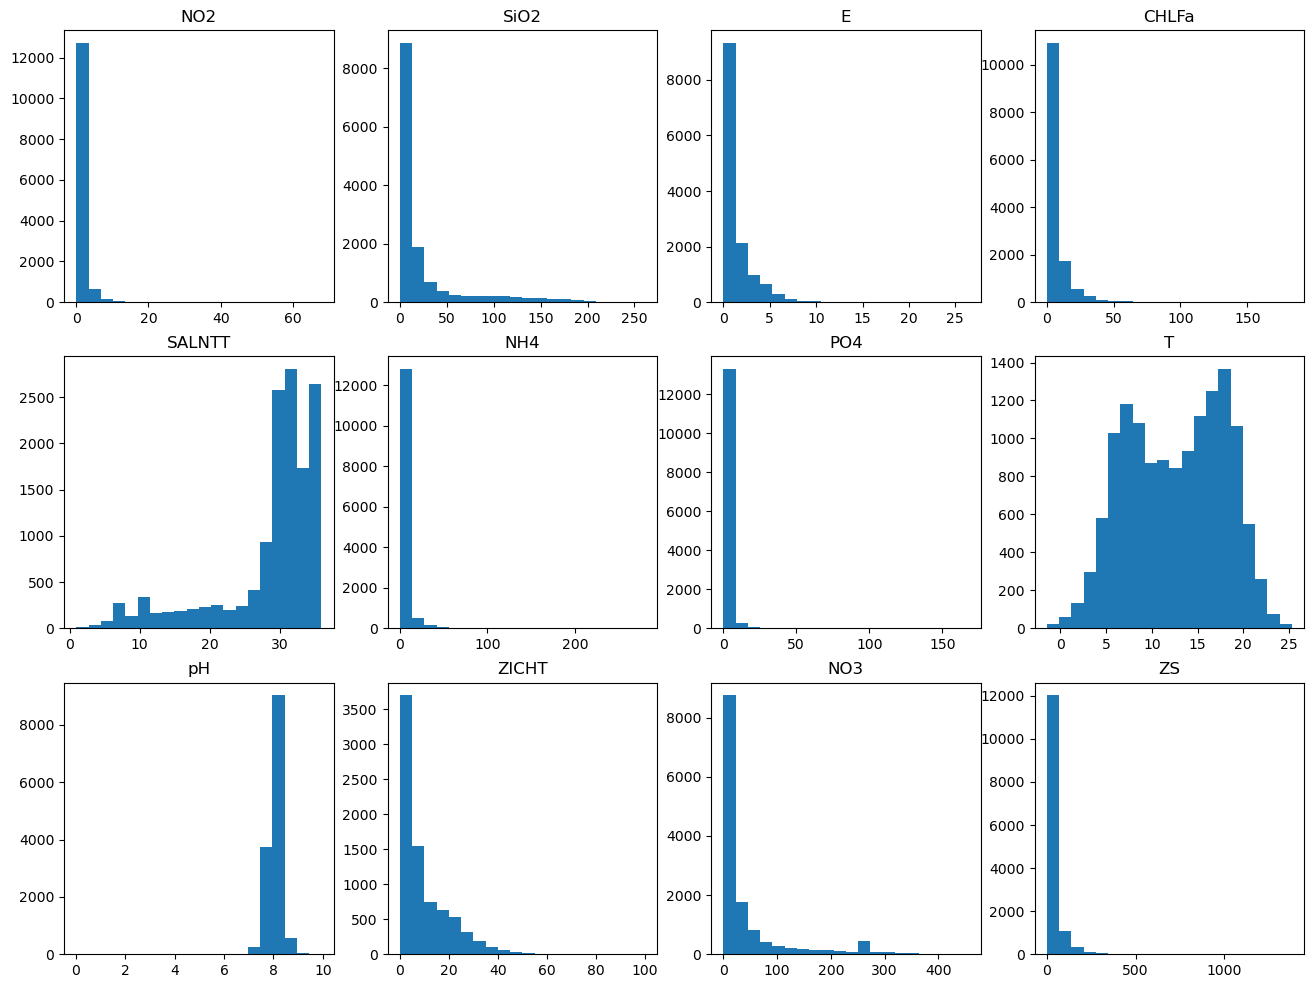

In [248]:
# lets do a lil interpolatin :O
interpolated_abiotic_df = abiotic_df.groupby("LOC_CODE").apply(lambda group: group.interpolate(method="linear", limit_direction="both")).reset_index(drop=True)

plot_data_distributions(interpolated_abiotic_df, bins=20)

percent_missing = interpolated_abiotic_df.isnull().sum() * 100 / len(interpolated_abiotic_df)

print(percent_missing.to_string())

In [249]:
parameter_columns = list(set(abiotic_columns) - location_time_set)

# we gotta normalize the values for the different variables prior to analysis
abio_data_scaler = StandardScaler()

abio_data_scaler.fit(interpolated_abiotic_df[parameter_columns])
normalized_data = abio_data_scaler.transform(interpolated_abiotic_df[parameter_columns])

# we normalized the values for all parameters
interpolated_abiotic_df[parameter_columns] = normalized_data

# however, since the ZICHT column is still missing a lot of data, we simply drop it for analysis for now
parameters_minus_ZICHT = list(set(parameter_columns) - {"ZICHT"})

abiotic_PCA = PCA(n_components=3)
abiotic_PCA.fit(interpolated_abiotic_df[parameters_minus_ZICHT])
low_dim_result = abiotic_PCA.transform(interpolated_abiotic_df[parameters_minus_ZICHT])

print("Before PCA: ",interpolated_abiotic_df.shape , "\nAfter PCA: ", low_dim_result.shape)
display(low_dim_result)


Before PCA:  (13611, 14) 
After PCA:  (13611, 3)


array([[ 0.92808081,  1.89071662, -1.5067229 ],
       [ 1.69340312,  2.59935312, -3.14139276],
       [-0.68944619,  1.14640244,  0.31328907],
       ...,
       [-1.62866673, -0.29282435,  0.28933237],
       [-1.47248811, -0.45591878,  0.17730886],
       [-1.34746884, -0.9343535 , -0.28440392]])

Text(0.5, 0.92, '3D PCA plot')

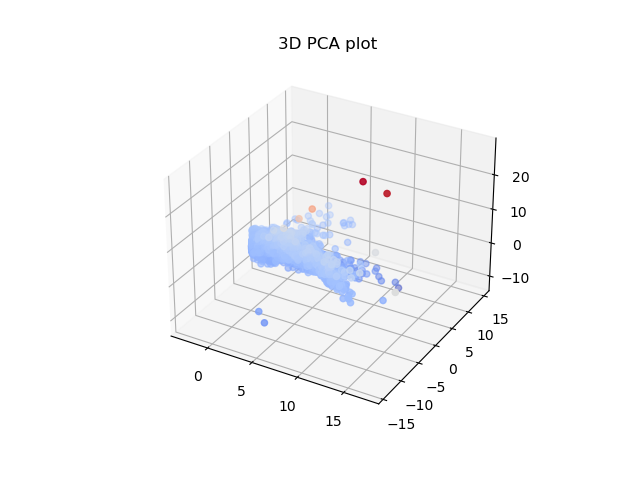

In [253]:
%matplotlib widget 
 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(low_dim_result[:, 0], low_dim_result[:, 1], low_dim_result[:, 2], c=low_dim_result[:, 2], cmap='coolwarm')
  
ax.set_title("3D PCA plot") 
  

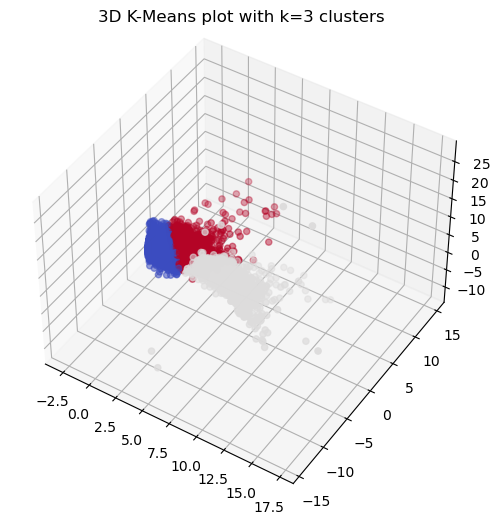

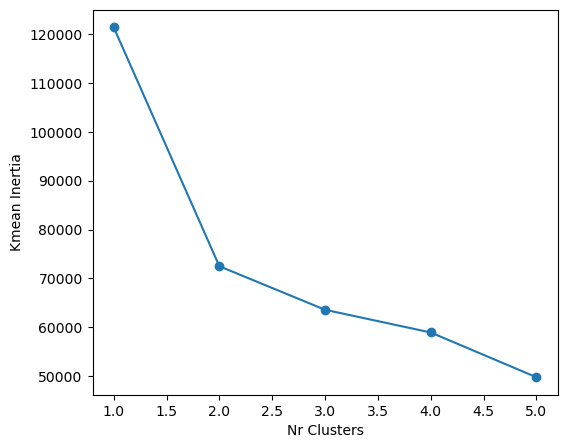

In [260]:
%matplotlib inline 

def plot_inertia(input, nr_clusters_limit):
    inertia_list = []

    cluster_counts = range(1,nr_clusters_limit)

    for nr_clusters in cluster_counts:
        abiotic_kmeans = KMeans(n_clusters=nr_clusters, n_init='auto')
        abiotic_kmeans.fit(input)
        inertia_list.append(abiotic_kmeans.inertia_)

    fig = plt.figure(figsize=(6, 5))

    plt.plot(cluster_counts, inertia_list, marker='o')
    plt.xlabel('Nr Clusters')
    plt.ylabel('Kmean Inertia')

plot_inertia(low_dim_result, 6)

Text(0.5, 0.92, '3D K-Means plot with k=3 clusters')

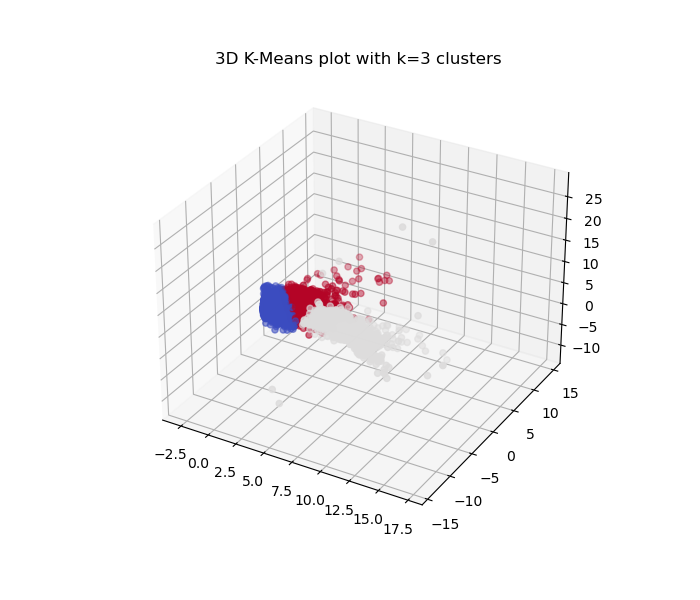

In [257]:
%matplotlib widget 
# as can be seen above, the value of k=3 would be a fine value for the clustering
optimal_clusters = 3

abiotic_kmeans = KMeans(n_clusters=optimal_clusters, n_init='auto')
abiotic_kmeans.fit(low_dim_result)

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(projection='3d')

ax.scatter(low_dim_result[:, 0], low_dim_result[:, 1], low_dim_result[:, 2], c=abiotic_kmeans.labels_, cmap='coolwarm')
  
ax.set_title(f"3D K-Means plot with k={optimal_clusters} clusters") 

(13611, 20)
[[2]
 [2]
 [0]
 ...
 [0]
 [0]
 [0]]
(13611, 21)
[-0.25743601  0.53690671  0.57270802 ...  0.37886941  0.08363674
  0.40223873]
[2 2 0 ... 0 0 0]


Text(0.5, 0.92, '3D K-Means plot with k=3 clusters')

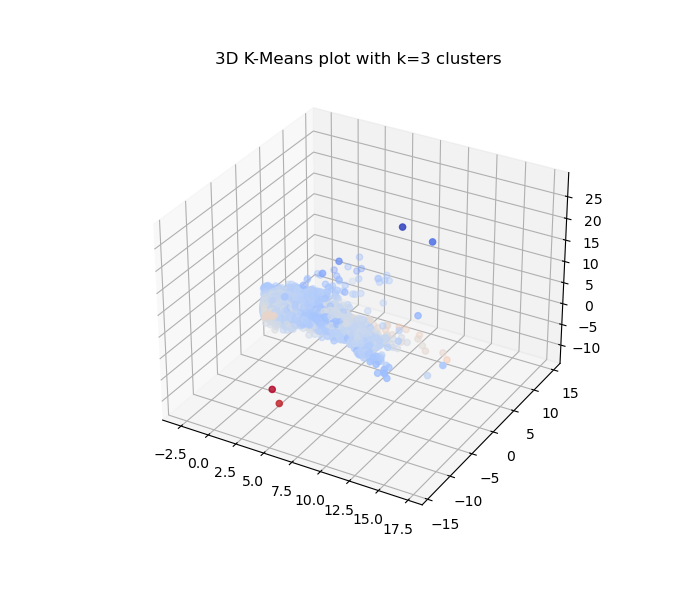

In [284]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(projection='3d')

print(low_dim_result.shape)
print(np.asarray(abiotic_kmeans.labels_).reshape(len(abiotic_kmeans.labels_), 1))

low_dim_result = np.hstack((low_dim_result, np.asarray(abiotic_kmeans.labels_).reshape(len(abiotic_kmeans.labels_), 1)))

print(low_dim_result.shape)

print(low_dim_result[:, 3])
print(abiotic_kmeans.labels_)

ax.scatter(low_dim_result[:, 0], low_dim_result[:, 1], low_dim_result[:, 2], c=low_dim_result[:, 3], cmap='coolwarm')
  
ax.set_title(f"3D K-Means plot with k={optimal_clusters} clusters") 

---
## Higher-Dimensional PCA Analysis

Before PCA:  (13611, 14) 
After PCA:  (13611, 5)


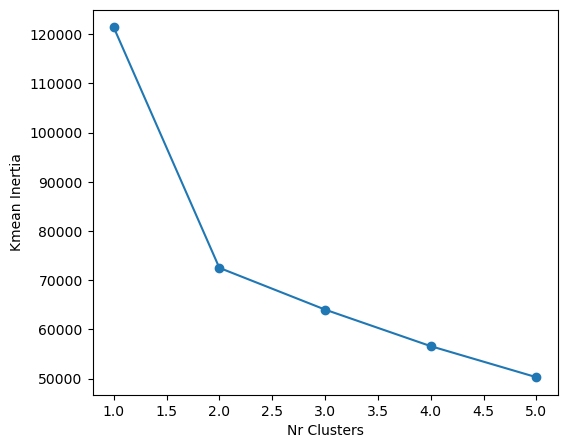

In [263]:
PCA_component_count = 5

abiotic_PCA = PCA(n_components=PCA_component_count)
abiotic_PCA.fit(interpolated_abiotic_df[parameters_minus_ZICHT])
low_dim_result = abiotic_PCA.transform(interpolated_abiotic_df[parameters_minus_ZICHT])

print("Before PCA: ",interpolated_abiotic_df.shape , "\nAfter PCA: ", low_dim_result.shape)

plot_inertia(low_dim_result, 6)


In [264]:
# as can be seen above, the value of k=3 would be a fine value for the clustering
optimal_clusters = 3

abiotic_kmeans_high_dim = KMeans(n_clusters=optimal_clusters, n_init='auto')
abiotic_kmeans_high_dim.fit(low_dim_result)

print(abiotic_kmeans_high_dim.labels_)

# fig = plt.figure(figsize=(7, 6))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(low_dim_result[:, 0], low_dim_result[:, 1], low_dim_result[:, 2], c=abiotic_kmeans.labels_, cmap='coolwarm')
  
# ax.set_title(f"3D K-Means plot with k={optimal_clusters} clusters") 

[2 2 2 ... 0 0 0]
